In [28]:
# Standard definitions needed for script
import numpy as np
import matplotlib.pyplot as plt
import numpy.ma as ma
import math
from astropy.table import Table
from astropy.io import fits
import astropy.units as u
from astropy.coordinates.sky_coordinate import SkyCoord
from astropy.units import Quantity
from numpy.polynomial.polynomial import polyfit
import astropy.constants as const
from astropy.coordinates import Angle
import pickle
import pandas as pd
from matplotlib.patches import Rectangle
%matplotlib inline

In [2]:
file = 'Data/GAIA_data2.pkl'
with open(file,'rb') as f: 
    data = pickle.load(f)
GTab = data['GTab']

print (GTab.colnames)
Gra = GTab["ra"]
Gdec = GTab["dec"]
Gpmra = GTab["pmra"]
Gpmra_e = GTab["pmra_error"]
Gpmdec = GTab["pmdec"]
Gpmdec_e = GTab["pmdec_error"]
Gpar = GTab["parallax"]
Gpar_sn = GTab["parallax_over_error"]
Gsepar = GTab["angular_distance"]
G2MASS = GTab["designation_2"]
g = GTab["phot_g_mean_mag"]
b = GTab["phot_bp_mean_mag"]
r = GTab["phot_rp_mean_mag"]
print(" GAIA Table contains ",len(Gra)," sources")

#calculate distance in pc and proper motion in km/s
Gdist = 1000./Gpar
Gpmra_km = (Gpmra*Gdist*const.au.value)/(u.yr.to('s')*1000.)
Gpmdec_km = (Gpmdec*Gdist*const.au.value)/(u.yr.to('s')*1000.)

['solution_id', 'designation', 'source_id', 'random_index', 'ref_epoch', 'ra', 'ra_error', 'dec', 'dec_error', 'parallax', 'parallax_error', 'parallax_over_error', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'ra_dec_corr', 'ra_parallax_corr', 'ra_pmra_corr', 'ra_pmdec_corr', 'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr', 'parallax_pmra_corr', 'parallax_pmdec_corr', 'pmra_pmdec_corr', 'astrometric_n_obs_al', 'astrometric_n_obs_ac', 'astrometric_n_good_obs_al', 'astrometric_n_bad_obs_al', 'astrometric_gof_al', 'astrometric_chi2_al', 'astrometric_excess_noise', 'astrometric_excess_noise_sig', 'astrometric_params_solved', 'astrometric_primary_flag', 'astrometric_weight_al', 'astrometric_pseudo_colour', 'astrometric_pseudo_colour_error', 'mean_varpi_factor_al', 'astrometric_matched_observations', 'visibility_periods_used', 'astrometric_sigma5d_max', 'frame_rotator_object_type', 'matched_observations', 'duplicated_source', 'phot_g_n_obs', 'phot_g_mean_flux', 'phot_g_mean_flux_erro

In [3]:
#creates list of indentifiers from 2MASS? 

gaia_list = []
for i in range(0,len(G2MASS)):
    gaia_list.append(G2MASS[i].decode('utf-8'))

In [4]:
#read in gould belt YSO catalog

infile = "Data/SERAQU-YSOs.tbl"
GBYSO = Table.read(infile,format="ascii.ipac")
# print(GBYSO.colnames)
GBYSOra = GBYSO["ra"]
GBYSOdec = GBYSO["dec"]
GBYSO2MASS = GBYSO["id2mass"]
print("Read ",len(GBYSOra)," YSOs from GB YSO catalog")

#match up GAIA catalog and Gould Belt YSO
GBYSO_match = np.empty(len(GBYSO2MASS),dtype=int); GBYSO_match.fill(-2)
for j in range(0,len(GBYSO2MASS)):
    if(GBYSO2MASS[j] in gaia_list):
        GBYSO_match[j] = gaia_list.index(GBYSO2MASS[j])
    else:
        GBYSO_match[j] = -2
good_GBYSO = GBYSO_match > -1
print(len(GBYSO_match[good_GBYSO]))
print(np.where(GBYSO_match > -1))

Read  1442  YSOs from GB YSO catalog
100
(array([ 128,  129,  130,  150,  160,  179,  184,  187,  194,  196,  202,
        212,  253,  258,  265,  279,  281,  282,  309,  347,  348,  349,
        360,  371,  380,  382,  428,  433,  441,  446,  495,  520,  690,
        694,  730,  734,  762,  791,  793,  833,  844,  875,  889,  939,
        942,  961,  962,  964,  974,  975,  978,  979,  982,  987,  992,
       1036, 1042, 1043, 1047, 1059, 1067, 1068, 1093, 1095, 1132, 1133,
       1138, 1145, 1155, 1185, 1213, 1226, 1227, 1233, 1253, 1255, 1258,
       1269, 1276, 1286, 1288, 1292, 1300, 1307, 1312, 1315, 1324, 1326,
       1327, 1330, 1331, 1341, 1345, 1356, 1388, 1402, 1406, 1417, 1420,
       1427]),)


In [5]:
#read in gould belt stars + dust catalgog

infile = "Data/SERP_GB_star+dust.tbl"
GBSD = Table.read(infile,format="ascii.ipac")
# print(GBSD.colnames)
GBSDra = GBSD["ra"]
GBSDdec = GBSD["dec"]
GBSD2MASS = GBSD["id2mass"]
print("Read ",len(GBSDra)," YSOs from GB Star+Dust catalog")

#match up GAIA catalog and Gould Belt stars+dust
GBSD_match = np.empty(len(GBSD2MASS),dtype=int); GBSD_match.fill(-2)
for j in range(0,len(GBSD2MASS)):
    if(GBSD2MASS[j] in gaia_list):
        GBSD_match[j] = gaia_list.index(GBSD2MASS[j])
    else:
        GBSD_match[j] = -2
good_GBSD = GBSD_match > -1
print(len(GBSD_match[good_GBSD]))
print(np.where(GBSD_match > -1))

Read  3725  YSOs from GB Star+Dust catalog
97
(array([ 690,  744,  749,  850,  891,  893,  949,  989, 1170, 1185, 1213,
       1280, 1291, 1311, 1336, 1400, 1401, 1414, 1437, 1470, 1506, 1583,
       1627, 1721, 1764, 1781, 1793, 1799, 1880, 1907, 1956, 2005, 2079,
       2107, 2178, 2186, 2188, 2194, 2212, 2219, 2223, 2226, 2233, 2254,
       2304, 2330, 2572, 2615, 2642, 2751, 2752, 2859, 2902, 2920, 2956,
       3084, 3119, 3127, 3129, 3133, 3136, 3138, 3170, 3175, 3213, 3267,
       3271, 3287, 3304, 3310, 3326, 3330, 3344, 3346, 3366, 3369, 3372,
       3375, 3380, 3406, 3417, 3435, 3465, 3478, 3480, 3488, 3489, 3494,
       3501, 3512, 3521, 3530, 3542, 3549, 3625, 3697, 3719]),)


In [6]:
#read in c2d YSO catalog 

infile = "Data/catalog-SER-YSOc.tbl"
c2dYSO = Table.read(infile,format="ascii.ipac")
#print(c2dYSO.colnames)
c2dYSOra = c2dYSO["ra"]
c2dYSOdec = c2dYSO["dec"]
c2dYSO2MASS = c2dYSO["id2mass"]
c2dYSOobj = c2dYSO["object_type"]
print("Read ",len(c2dYSOra)," YSOs from c2d YSO catalog")

#match up GAIA catalog and c2d YSO catalog
c2dYSO_match = np.empty(len(c2dYSO2MASS),dtype=int); c2dYSO_match.fill(-2)
for j in range(0,len(c2dYSO2MASS)):
    if(c2dYSO2MASS[j] in gaia_list):
        c2dYSO_match[j] = gaia_list.index(c2dYSO2MASS[j])
    else:
        c2dYSO_match[j] = -2
good_c2dYSO = c2dYSO_match > -1
print(len(c2dYSO_match[good_c2dYSO]))
print(np.where(c2dYSO_match > -1))

Read  262  YSOs from c2d YSO catalog
95
(array([  0,   6,   9,  10,  11,  15,  16,  33,  36,  43,  53,  54,  56,
        57,  59,  61,  63,  64,  67,  70,  72,  77,  78,  79,  81,  85,
        87,  95,  98, 101, 103, 112, 113, 115, 116, 119, 120, 123, 125,
       127, 131, 132, 134, 136, 137, 138, 139, 140, 141, 142, 144, 145,
       159, 162, 172, 174, 175, 179, 182, 184, 186, 187, 189, 195, 197,
       198, 200, 207, 208, 211, 212, 213, 218, 225, 228, 231, 232, 233,
       235, 237, 238, 239, 242, 243, 245, 246, 249, 250, 251, 252, 255,
       256, 257, 259, 261]),)


In [7]:
#read in c2d YSO stars+dust catalog

infile = "Data/SERP_c2d_star+dust.tbl"
c2dSD = Table.read(infile,format="ascii.ipac")
# print(GBSD.colnames)
c2dSDra = c2dSD["ra"]
c2dSDdec = c2dSD["dec"]
c2dSD2MASS = c2dSD["id2mass"]
print("Read ",len(c2dSDra)," YSOs from c2d Star+Dust catalog")

#match up GAIA catalog and c2d YSO catalog
c2dSD_match = np.empty(len(c2dSD2MASS),dtype=int); c2dSD_match.fill(-2)
for j in range(0,len(c2dSD2MASS)):
    if(c2dSD2MASS[j] in gaia_list):
        c2dSD_match[j] = gaia_list.index(c2dSD2MASS[j])
    else:
        c2dSD_match[j] = -2
good_c2dSD = c2dSD_match > -1
print(len(c2dSD_match[good_c2dSD]))
print(np.where(c2dSD_match > -1))

Read  256  YSOs from c2d Star+Dust catalog
24
(array([  2,  29,  51,  54, 126, 128, 142, 147, 153, 156, 171, 175, 191,
       193, 201, 214, 217, 219, 223, 224, 228, 235, 238, 251]),)


In [8]:
#total number of YSO matches

YSO_match = c2dYSO_match; YSO_match = np.append(YSO_match,GBYSO_match)
good_YSO = YSO_match > -1
print("Total number of GAIA matches to YSOs: ",len(YSO_match[good_YSO]))
SD_match = c2dSD_match; SD_match = np.append(SD_match,GBSD_match)
good_SD = SD_match > -1
print("Total number of GAIA matches to star+dust: ",len(SD_match[good_SD]))
All_YSO = YSO_match
All_YSO = np.append(All_YSO,SD_match)
good_all = All_YSO > -1
print("Total number of all matches: ",len(All_YSO[good_all]))

Total number of GAIA matches to YSOs:  195
Total number of GAIA matches to star+dust:  121
Total number of all matches:  316


In [60]:
#Coordinates that indicate regions

#region 1
ra_min1 = 279
ra_max1 = 280.1
dec_min1 = -1
dec_max1 = 1
width1 = (ra_max1-ra_min1)
height1 = (dec_max1 - dec_min1)

#region 2
ra_min2 = 276.5
ra_max2 = 278.5
dec_min2 = -4.5
dec_max2 = -2
width2 = (ra_max2-ra_min2)
height2 = (dec_max2 - dec_min2)

#region 3
ra_min3 = 276.75
ra_max3 = 277.75
dec_min3 = -1
dec_max3 = 2
width3 = (ra_max3-ra_min3)
height3 = (dec_max3 - dec_min3)

Number of YSO matches in the correct distance interval:  147
Number of YSO with parallax > 5, 10, 20:  135 86 43


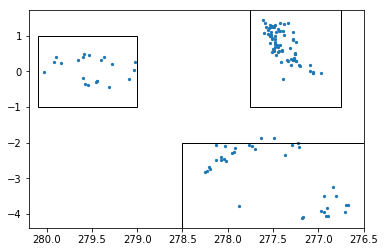

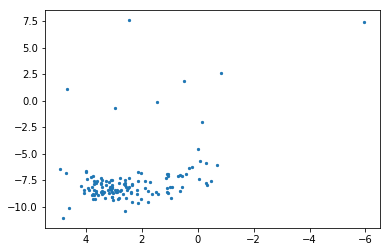

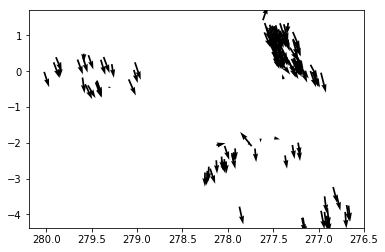

Mean proper motion (Ra,Dec):  2.55007583446 -7.3051741763
Median proper motion (Ra,Dec):  2.94607506771 -8.24536802149


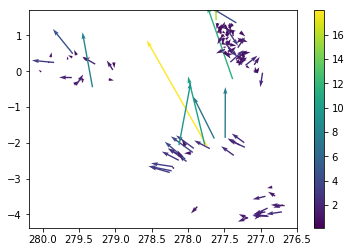

In [62]:
#properties of good YSO matches
raYSO = np.zeros(len(YSO_match[good_YSO]))
decYSO = np.zeros(len(YSO_match[good_YSO]))
pmraYSO = np.zeros(len(YSO_match[good_YSO]))
pmdecYSO = np.zeros(len(YSO_match[good_YSO]))
pmra_eYSO = np.zeros(len(YSO_match[good_YSO]))
pmdec_eYSO = np.zeros(len(YSO_match[good_YSO]))
parYSO = np.zeros(len(YSO_match[good_YSO]))
par_snYSO = np.zeros(len(YSO_match[good_YSO]))
distYSO = np.zeros(len(YSO_match[good_YSO]))
pmra_kmYSO = np.zeros(len(YSO_match[good_YSO]))
pmdec_kmYSO = np.zeros(len(YSO_match[good_YSO]))
nyso = 0

#find number of YSO matches in the correct interval
for i in range(0,len(YSO_match)):
    if(YSO_match[i] > -1):
        j = YSO_match[i]
        if(1000./Gpar[j] > 350. and 1000/Gpar[j] < 550.):
            raYSO[nyso] = Gra[j]
            decYSO[nyso] = Gdec[j]
            pmraYSO[nyso] = Gpmra[j]
            pmdecYSO[nyso] = Gpmdec[j]
            parYSO[nyso] = Gpar[j]
            par_snYSO[nyso] = Gpar_sn[j]
            distYSO[nyso] = Gdist[j]
            pmra_kmYSO[nyso] = Gpmra_km[j]
            pmdec_kmYSO[nyso] = Gpmdec_km[j]
            nyso = nyso + 1        
print("Number of YSO matches in the correct distance interval: ",nyso)

#find number of YSOs within parallax S/N greater than certain amount
parsn10 = par_snYSO > 10.
parsn5 = par_snYSO > 5
parsn20 = par_snYSO > 20
print("Number of YSO with parallax > 5, 10, 20: ", len(par_snYSO[parsn5]),len(par_snYSO[parsn10]),len(par_snYSO[parsn20]))

#scatter plot of ra and dec
plt.scatter(raYSO[parsn5],decYSO[parsn5],s=5)
plt.gca().invert_xaxis()
plt.gca().add_patch(Rectangle((ra_min1,dec_min1),width1,height1,fill=False))
plt.gca().add_patch(Rectangle((ra_min2,dec_min2),width2,height2,fill=False))
plt.gca().add_patch(Rectangle((ra_min3,dec_min3),width3,height3,fill=False))
plt.show()
#scatter plot of proper motions
plt.scatter(pmraYSO[parsn5],pmdecYSO[parsn5],s=5)
plt.gca().invert_xaxis()
plt.show()
#plot of YSOs at ra and dec with proper motions
plt.quiver(raYSO[parsn5],decYSO[parsn5],pmraYSO[parsn5],pmdecYSO[parsn5])
plt.gca().invert_xaxis()
plt.show()
#mean proper motions
mean_pmra = np.mean(pmraYSO[parsn10])
mean_pmdec = np.mean(pmdecYSO[parsn10])
print("Mean proper motion (Ra,Dec): ",mean_pmra,mean_pmdec)
#median proper motions
median_pmra = np.median(pmraYSO[parsn10])
median_pmdec = np.median(pmdecYSO[parsn10])
print("Median proper motion (Ra,Dec): ",median_pmra,median_pmdec)
#deviation from median of proper motion  of S/N > 10 ysos
rpmraYSO = pmraYSO - median_pmra
rpmdecYSO = pmdecYSO - median_pmdec
#magnitude of deviation from median of proper motion
pmmagYSO = np.zeros(len(YSO_match[good_YSO]))
pmmagYSO = np.power((rpmraYSO*rpmraYSO+rpmdecYSO*rpmdecYSO),0.5)
#plot of YSOs at ra and dec with deviation from median of proper motion
plt.quiver(raYSO[parsn5],decYSO[parsn5],rpmraYSO[parsn5],rpmdecYSO[parsn5],pmmagYSO[parsn5])
plt.gca().invert_xaxis()
plt.colorbar()
plt.show()

In [10]:
#determine high proper motion YSOs 
high_pmYSO = pmmagYSO[parsn5] > 8.
for i in range(0,len(high_pmYSO)):
    if(high_pmYSO[i]):
        j = YSO_match[i] #identifier of YSO match
        print(Gra[j],Gdec[j],c2dYSOobj[i],rpmraYSO[i],rpmdecYSO[i],pmmagYSO[i])

279.453790029 -4.79575643825 YSOc_star+dust(IR2) -3.76667603881 10.820689126 11.4575373246
279.453790029 -4.79575643825 YSOc_star+dust(IR2) 0.703297274399 2.74306354307 2.83178824376
279.453790029 -4.79575643825 YSOc -0.869465456387 2.89188610589 3.01976413471
277.332099703 0.300794132453 YSOc_star+dust(IR2) -2.80033359482 -0.436740417832 2.83418602686
279.453790029 -4.79575643825 YSOc_star+dust(IR2) -2.62941411494 1.92025486412 3.25594799268
279.453790029 -4.79575643825 YSOc_star+dust(IR4) -0.79875021553 1.52186386729 1.7187412654


In [11]:
#FIXED determine high proper motion YSOs
for i in range(0,len(pmmagYSO)):
    if(pmmagYSO[i] > 8): 
        j = YSO_match[i] #identifier of YSO match
        print(Gra[j],Gdec[j],c2dYSOobj[i],rpmraYSO[i],rpmdecYSO[i],pmmagYSO[i],par_snYSO[i])
        #figure out difference between i and j

279.453790029 -4.79575643825 YSOc_star+dust(IR2) -3.76667603881 10.820689126 11.4575373246 52.1638450623
279.453790029 -4.79575643825 YSOc_star+dust(MP1) -0.474765863873 15.8194040945 15.8265267362 83.362991333
279.453790029 -4.79575643825 YSOc_star+dust(IR3) -8.90924898894 15.6353749195 17.9955457383 74.2138214111
279.453790029 -4.79575643825 YSOc_star+dust(MP1) -2.46857193192 10.0882754638 10.3859110922 47.1941757202
277.3889497 1.13825537835 YSOc_PAH-em 1.75052523789 9.33831884282 9.50097560352 30.1823787689
279.453790029 -4.79575643825 YSOc_star+dust(IR3) -1.4867043421 8.13160795946 8.2663981157 40.8754005432
279.453790029 -4.79575643825 YSOc_red -2.94607506771 8.24536802149 8.75588100161 0.0
279.453790029 -4.79575643825 YSOc_red -2.94607506771 8.24536802149 8.75588100161 0.0
279.453790029 -4.79575643825 YSOc_star+dust(IR4) -2.94607506771 8.24536802149 8.75588100161 0.0
279.453790029 -4.79575643825 YSOc_red -2.94607506771 8.24536802149 8.75588100161 0.0
279.453790029 -4.79575643825

In [12]:
print(len(YSO_match))
print(len(high_pmYSO))

1704
135


Number of Star+dusts sources in distance interval:  82
Number of SD with parallax > 5, 10, 20:  65 43 26


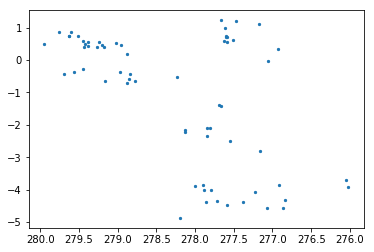

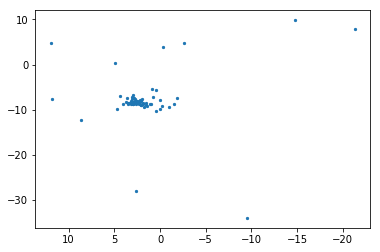

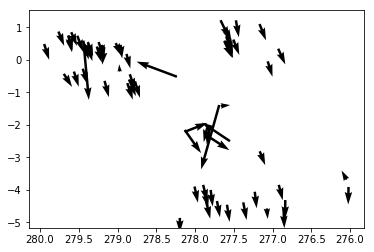

Mean proper motion (Ra,Dec):  1.47433185251 -6.4365700493
Median proper motion (Ra,Dec):  2.94607506771 -8.24536802149


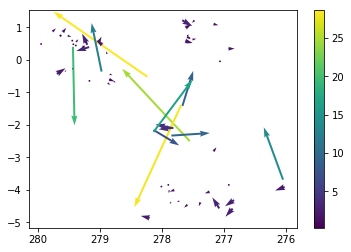

In [13]:
#properties of good star + dust matches
raSD = np.zeros(len(SD_match[good_SD]))
decSD = np.zeros(len(SD_match[good_SD]))
pmraSD = np.zeros(len(SD_match[good_SD]))
pmdecSD = np.zeros(len(SD_match[good_SD]))
pmra_eSD = np.zeros(len(SD_match[good_SD]))
pmdec_eSD = np.zeros(len(SD_match[good_SD]))
parSD = np.zeros(len(SD_match[good_SD]))
par_snSD = np.zeros(len(SD_match[good_SD]))
pmmagSD = np.zeros(len(SD_match[good_SD]))
distSD = np.zeros(len(SD_match[good_SD]))
pmra_kmSD = np.zeros(len(SD_match[good_SD]))
pmdec_kmSD = np.zeros(len(SD_match[good_SD]))
nsd = 0

#find number of star+dust matches in the correct interval
for i in range(0,len(SD_match)):
    if(SD_match[i] > -1):
        j = SD_match[i]
        if(1000./Gpar[j] > 350. and 1000./Gpar[j]<550):
            raSD[nsd] = Gra[j]
            decSD[nsd] = Gdec[j]
            pmraSD[nsd] = Gpmra[j]
            pmdecSD[nsd] = Gpmdec[j]
            parSD[nsd] = Gpar[j]
            par_snSD[nsd] = Gpar_sn[j]
            distSD[nsd] = Gdist[j]
            pmra_kmSD[nsd] = Gpmra_km[j]
            pmdec_kmSD[nsd] = Gpmdec_km[j]
            nsd = nsd + 1
print("Number of Star+dusts sources in distance interval: ",nsd)

#find number of star+dust within parallax S/N greater than certain amount
parsn10SD = par_snSD > 10.
parsn5SD = par_snSD > 5
parsn20SD = par_snSD > 20
print("Number of SD with parallax > 5, 10, 20: ", len(par_snSD[parsn5SD]),len(par_snSD[parsn10SD]),len(par_snSD[parsn20SD]))

#scatter plot of ra and dec
plt.scatter(raSD[parsn5SD],decSD[parsn5SD],s=5)
plt.gca().invert_xaxis()
plt.show()
#scatter plot of proper motion in ra and dec
plt.scatter(pmraSD[parsn5SD],pmdecSD[parsn5SD],s=5)
plt.gca().invert_xaxis()
plt.show()
#plot of stars+dust at ra and dec with proper motion vector indciated
plt.quiver(raSD[parsn5SD],decSD[parsn5SD],pmraSD[parsn5SD],pmdecSD[parsn5SD])
plt.gca().invert_xaxis()
plt.show()
#mean proper motion in ra and dec
mean_pmraSD = np.mean(pmraSD[parsn10SD])
mean_pmdecSD = np.mean(pmdecSD[parsn10SD])
print("Mean proper motion (Ra,Dec): ",mean_pmraSD,mean_pmdecSD)
#median proper motion in ra and dec
median_pmraSD = np.median(pmraSD[parsn10SD])
median_pmdecSD = np.median(pmdecSD[parsn10SD])
print("Median proper motion (Ra,Dec): ",median_pmra,median_pmdec)
#
rpmraSD = pmraSD - median_pmraSD
rpmdecSD = pmdecSD - median_pmdecSD
pmmagSD = np.zeros(len(SD_match[good_SD]))
pmmagSD = np.power((rpmraSD*rpmraSD+rpmdecSD*rpmdecSD),0.5)
plt.quiver(raSD[parsn5SD],decSD[parsn5SD],rpmraSD[parsn5SD],rpmdecSD[parsn5SD],pmmagSD[parsn5SD])
plt.gca().invert_xaxis()
plt.colorbar()
plt.show()

Number of Star+dusts sources in distance interval:  229
Number of SD with parallax > 5, 10, 20:  200 129 69


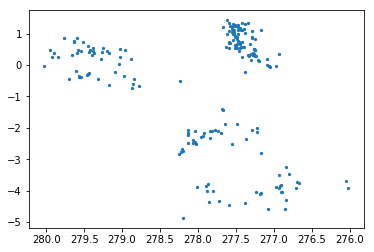

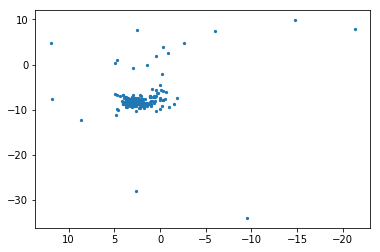

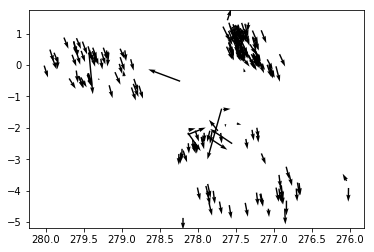

Mean proper motion (Ra,Dec):  2.19149450714 -7.0156394673
Median proper motion (Ra,Dec):  2.74805729747 -8.28196093477


/astromake/opt/python/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:63: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 5685 but corresponding boolean dimension is 1704


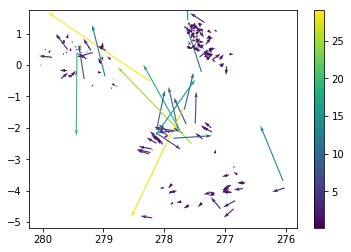

In [14]:
#properties of good star + dust matches
raALL = np.zeros(len(All_YSO[good_all]))
decALL = np.zeros(len(All_YSO[good_all]))
pmraALL = np.zeros(len(All_YSO[good_all]))
pmdecALL = np.zeros(len(All_YSO[good_all]))
pmra_eALL = np.zeros(len(All_YSO[good_all]))
pmdec_eALL = np.zeros(len(All_YSO[good_all]))
parALL = np.zeros(len(All_YSO[good_all]))
par_snALL = np.zeros(len(All_YSO[good_all]))
pmmagALL = np.zeros(len(All_YSO[good_all]))
distALL = np.zeros(len(All_YSO[good_all]))
pmra_kmALL = np.zeros(len(All_YSO[good_all]))
pmdec_kmALL = np.zeros(len(All_YSO[good_all]))

nALL = 0

#find number of star+dust matches in the correct interval
for i in range(0,len(All_YSO)):
    if(All_YSO[i] > -1):
        j = All_YSO[i]
        if(1000./Gpar[j] > 350. and 1000./Gpar[j]<550):
            raALL[nALL] = Gra[j]
            decALL[nALL] = Gdec[j]
            pmraALL[nALL] = Gpmra[j]
            pmdecALL[nALL] = Gpmdec[j]
            parALL[nALL] = Gpar[j]
            par_snALL[nALL] = Gpar_sn[j]
            distALL[nALL] = Gdist[j]
            pmra_kmALL[nALL] = Gpmra_km[j]
            pmdec_kmALL[nALL] = Gpmdec_km[j]
            nALL = nALL + 1
print("Number of Star+dusts sources in distance interval: ",nALL)

#find number of star+dust within parallax S/N greater than certain amount
parsn10ALL = par_snALL > 10.
parsn5ALL = par_snALL > 5
parsn20ALL = par_snALL > 20
print("Number of SD with parallax > 5, 10, 20: ", len(par_snALL[parsn5ALL]),len(par_snALL[parsn10ALL]),\
      len(par_snALL[parsn20ALL]))

#scatter plot of ra and dec
plt.scatter(raALL[parsn5ALL],decALL[parsn5ALL],s=5)
plt.gca().invert_xaxis()
plt.show()
#scatter plot of proper motion in ra and dec
plt.scatter(pmraALL[parsn5ALL],pmdecALL[parsn5ALL],s=5)
plt.gca().invert_xaxis()
plt.show()
#plot of stars+dust at ra and dec with proper motion vector indciated
plt.quiver(raALL[parsn5ALL],decALL[parsn5ALL],pmraALL[parsn5ALL],pmdecALL[parsn5ALL])
plt.gca().invert_xaxis()
plt.show()
#mean proper motion in ra and dec
mean_pmraALL = np.mean(pmraALL[parsn10ALL])
mean_pmdecALL = np.mean(pmdecALL[parsn10ALL])
print("Mean proper motion (Ra,Dec): ",mean_pmraALL,mean_pmdecALL)
#median proper motion in ra and dec
median_pmraALL = np.median(pmraALL[parsn10ALL])
median_pmdecALL = np.median(pmdecALL[parsn10ALL])
print("Median proper motion (Ra,Dec): ",median_pmraALL,median_pmdecALL)
#
rpmraALL = pmraALL - median_pmraALL
rpmdecALL = pmdecALL - median_pmdecALL
pmmagALL = np.zeros(len(All_YSO[good_YSO]))
pmmagALL = np.power((rpmraALL*rpmraALL+rpmdecALL*rpmdecALL),0.5)
plt.quiver(raALL[parsn5ALL],decALL[parsn5ALL],rpmraALL[parsn5ALL],rpmdecALL[parsn5ALL],pmmagALL[parsn5ALL])
plt.gca().invert_xaxis()
plt.colorbar()
plt.show()

Number of YSOs in Region 1:  21
Number of YSO with parallax > 5, 10, 20:  20 10 6


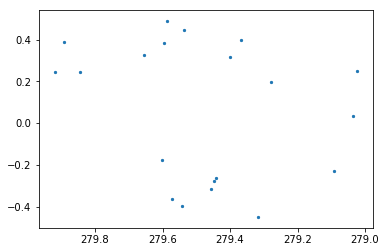

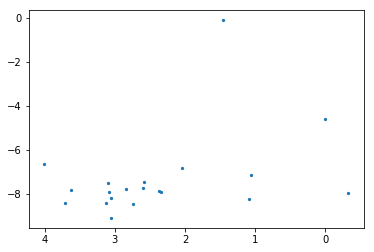

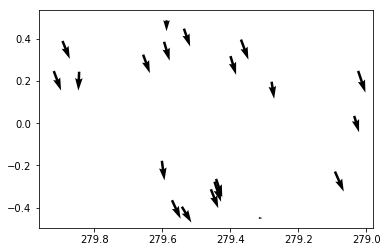

Mean proper motion (Ra,Dec):  2.695078171 -7.23845483364
Median proper motion (Ra,Dec):  2.79220300893 -7.89315436684


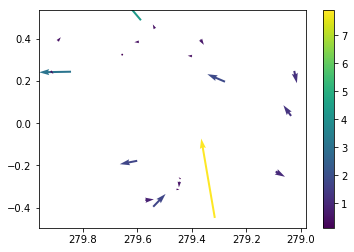

In [27]:
#Examine YSOs from the three regions

#region 1
#ra: 279 to 280, dec: 1 to -1

raYSO_1 = np.array([])
decYSO_1 = np.array([])
pmraYSO_1 = np.array([])
pmdecYSO_1 = np.array([])
pmra_eYSO_1 = np.array([])
pmdec_eYSO_1 = np.array([])
parYSO_1 = np.array([])
par_snYSO_1 = np.array([])
distYSO_1 = np.array([])
pmra_kmYSO_1 = np.array([])
pmdec_kmYSO_1 = np.array([])
nyso_region1 = 0

#find number of YSO matches in the correct interval
for i in range(len(raYSO)):
        if(raYSO[i] <= 280 and raYSO[i] >= 279 and decYSO[i] >= -1 and decYSO[i] <= 1):
            raYSO_1 = np.append(raYSO_1,raYSO[i])
            decYSO_1 = np.append(decYSO_1,decYSO[i])
            pmraYSO_1 = np.append(pmraYSO_1,pmraYSO[i])
            pmdecYSO_1 = np.append(pmdecYSO_1,pmdecYSO[i])
            parYSO_1 = np.append(parYSO_1,parYSO[i])
            par_snYSO_1 = np.append(par_snYSO_1,par_snYSO[i])
            distYSO_1 = np.append(distYSO_1,distYSO[i])
            pmra_kmYSO_1 = np.append(pmra_kmYSO_1,pmra_kmYSO[i])
            pmdec_kmYSO_1 = np.append(pmdec_kmYSO_1,pmdec_kmYSO[i])
            nyso_region1 = nyso_region1 + 1        
print("Number of YSOs in Region 1: ",nyso_region1)

#find number of YSOs within parallax S/N greater than certain amount
parsn10_1 = par_snYSO_1 > 10.
parsn5_1 = par_snYSO_1 > 5
parsn20_1 = par_snYSO_1 > 20
print("Number of YSO with parallax > 5, 10, 20: ", len(par_snYSO_1[parsn5_1]),\
      len(par_snYSO_1[parsn10_1]),len(par_snYSO_1[parsn20_1]))

#scatter plot of ra and dec
plt.scatter(raYSO_1[parsn5_1],decYSO_1[parsn5_1],s=5)
plt.gca().invert_xaxis()
plt.show()
#scatter plot of proper motions
plt.scatter(pmraYSO_1[parsn5_1],pmdecYSO_1[parsn5_1],s=5)
plt.gca().invert_xaxis()
plt.show()
#plot of YSOs at ra and dec with proper motions
plt.quiver(raYSO_1[parsn5_1],decYSO_1[parsn5_1],pmraYSO_1[parsn5_1],pmdecYSO_1[parsn5_1])
plt.gca().invert_xaxis()
plt.show()
#mean proper motions
mean_pmra_1 = np.mean(pmraYSO_1[parsn10_1])
mean_pmdec_1 = np.mean(pmdecYSO_1[parsn10_1])
print("Mean proper motion (Ra,Dec): ",mean_pmra_1,mean_pmdec_1)
#median proper motions
median_pmra_1 = np.median(pmraYSO_1[parsn10_1])
median_pmdec_1 = np.median(pmdecYSO_1[parsn10_1])
print("Median proper motion (Ra,Dec): ",median_pmra_1,median_pmdec_1)
#deviation from median of proper motion  of S/N > 10 ysos
rpmraYSO_1 = pmraYSO_1 - median_pmra_1
rpmdecYSO_1 = pmdecYSO_1 - median_pmdec_1
#magnitude of deviation from median of proper motion
pmmagYSO_1 = np.zeros(len(raYSO_1))
pmmagYSO_1 = np.power((rpmraYSO_1*rpmraYSO_1+rpmdecYSO_1*rpmdecYSO_1),0.5)
#plot of YSOs at ra and dec with deviation from median of proper motion
plt.quiver(raYSO_1[parsn5_1],decYSO_1[parsn5_1],rpmraYSO_1[parsn5_1],rpmdecYSO_1[parsn5_1],pmmagYSO_1[parsn5_1])
plt.gca().invert_xaxis()
plt.colorbar()
plt.show()

In [23]:
#region 2
#ra: 278.5 to 276.5, dec: -2.5 to-5

raYSO_2 = np.array([])
decYSO_2 = np.array([])
pmraYSO_2 = np.array([])
pmdecYSO_2 = np.array([])
pmra_eYSO_2 = np.array([])
pmdec_eYSO_2 = np.array([])
parYSO_2 = np.array([])
par_snYSO_2 = np.array([])
distYSO_2 = np.array([])
pmra_kmYSO_2 = np.array([])
pmdec_kmYSO_2 = np.array([])
nyso_region2 = 0

#find number of YSO matches in the correct interval
for i in range(len(raYSO)):
        if(raYSO[i] <= 278.5 and raYSO[i] >= 276.5 and decYSO[i] >= -5 and decYSO[i] <= -2.5):
            raYSO_2 = np.append(raYSO_2,raYSO[i])
            decYSO_2 = np.append(decYSO_2,decYSO[i])
            pmraYSO_2 = np.append(pmraYSO_2,pmraYSO[i])
            pmdecYSO_2 = np.append(pmdecYSO_2,pmdecYSO[i])
            parYSO_2 = np.append(parYSO_2,parYSO[i])
            par_snYSO_2 = np.append(par_snYSO_2,par_snYSO[i])
            distYSO_2 = np.append(distYSO_2,distYSO[i])
            pmra_kmYSO_2 = np.append(pmra_kmYSO_2,pmra_kmYSO[i])
            pmdec_kmYSO_2 = np.append(pmdec_kmYSO_2,pmdec_kmYSO[i])
            nyso_region2 = nyso_region2 + 1        
print("Number of YSOs in Region 2: ",nyso_region2)

Number of YSOs in Region 2:  20


In [25]:
#region 3
#ra: 278 to 277.5, dec: 2 to -1

raYSO_3 = np.array([])
decYSO_3 = np.array([])
pmraYSO_3 = np.array([])
pmdecYSO_3 = np.array([])
pmra_eYSO_3 = np.array([])
pmdec_eYSO_3 = np.array([])
parYSO_3 = np.array([])
par_snYSO_3 = np.array([])
distYSO_3 = np.array([])
pmra_kmYSO_3 = np.array([])
pmdec_kmYSO_3 = np.array([])
nyso_region3 = 0

#find number of YSO matches in the correct interval
for i in range(len(raYSO)):
        if(raYSO[i] <= 278 and raYSO[i] >= 277.5 and decYSO[i] <= 2 and decYSO[i] >= 1):
            raYSO_3 = np.append(raYSO_3,raYSO[i])
            decYSO_3 = np.append(decYSO_3,decYSO[i])
            pmraYSO_3 = np.append(pmraYSO_3,pmraYSO[i])
            pmdecYSO_3 = np.append(pmdecYSO_3,pmdecYSO[i])
            parYSO_3 = np.append(parYSO_3,parYSO[i])
            par_snYSO_3 = np.append(par_snYSO_3,par_snYSO[i])
            distYSO_3 = np.append(distYSO_3,distYSO[i])
            pmra_kmYSO_3 = np.append(pmra_kmYSO_3,pmra_kmYSO[i])
            pmdec_kmYSO_3 = np.append(pmdec_kmYSO_3,pmdec_kmYSO[i])
            nyso_region3 = nyso_region3 + 1        
print("Number of YSOs in Region 3: ",nyso_region3)

Number of YSOs in Region 3:  16


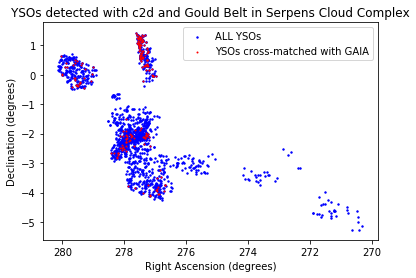

In [18]:
#combine ra and dec for all YSOs into an array for ra and an array for dec
c2dYSOra_data = np.array(c2dYSOra.data)
c2dYSOdec_data = np.array(c2dYSOdec.data)
GBYSOra_data = np.array(GBYSOra.data)
GBYSOdec_data = np.array(GBYSOdec.data)
YSO_ra = c2dYSOra_data; YSO_ra = np.append(YSO_ra,GBYSOra_data)
YSO_dec = c2dYSOdec_data; YSO_dec = np.append(YSO_dec,GBYSOdec_data)

#Plot of 
figure = plt.figure()
plt.scatter(YSO_ra,YSO_dec,c='b',s=2,label='ALL YSOs')
plt.scatter(YSO_ra[YSO_match >-1],YSO_dec[YSO_match >-1],c='r',s=1,label='YSOs cross-matched with GAIA')
plt.xlabel('Right Ascension (degrees)')
plt.ylabel('Declination (degrees)')
plt.title('YSOs detected with c2d and Gould Belt in Serpens Cloud Complex')
plt.legend()
plt.gca().invert_xaxis()
plt.savefig('Figures/YSO_plot.png')
plt.show()

#Do the distances need to be filtered? 

61441
Number of sources in distance range: 11867
11867


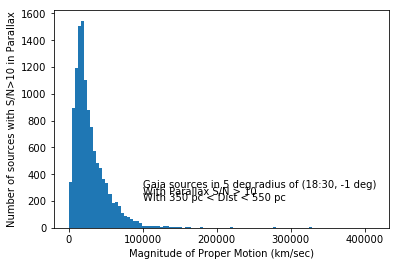

In [19]:
#define variables
ra_big = GTab["ra"]
dec_big = GTab["dec"]
par_big = GTab["parallax"]
pare_big = GTab["parallax_error"]
parsn_big = GTab["parallax_over_error"]
pmra_big = GTab["pmra"]
pmdec_big = GTab["pmdec"]
print(len(ra_big))

#count number of sources in distance range
nn = 0
for i in range(0,len(ra_big)):
     dist = 1000/par_big[i]
     if(dist > 350. and dist <550. and parsn_big[i]>10.):
         nn = nn + 1
print("Number of sources in distance range:", nn)


secperyr = 60*60*24*365.25
to_kms = 443./1000. * 1.496e8/secperyr

#find magnitude of proper motion for sources with S/N greater than 10 in parallax
pm_mag = np.zeros(0)
for i in range(0,len(ra_big)):
     dist = 1000/par_big[i]
     if (dist > 350. and dist <550. and parsn_big[i]>10.):
        
        pmra_km = (pmra_big[i]*dist*const.au.value)/(secperyr*1000.0)
        pmdec_km = (pmdec_big[i]*dist*const.au.value)/(secperyr*1000.0)
        #pm2 = pmra_big[i]*pmra_big[i] + pmdec_big[i]*pmdec_big[i]
        pm2 = pmra_km*pmra_km+pmdec_km*pmdec_km
        pm = np.power(pm2,0.5)
        pm_mag = np.append(pm_mag,pm)
        
print(len(pm_mag))

#create histogram of number of sources for each proper motion magnitude
plt.hist(pm_mag,bins=100)
plt.xlabel("Magnitude of Proper Motion (km/sec)")
plt.ylabel("Number of sources with S/N>10 in Parallax")
plt.text(100000,300,"Gaia sources in 5 deg radius of (18:30, -1 deg)")
plt.text(100000,250,"With Parallax S/N > 10")
plt.text(100000,200,"With 350 pc < Dist < 550 pc")
plt.savefig("big-Serp-pms.png")
plt.show()

In [50]:
WISE_YSO = Table.read('WISE_SVM_YSO_class1+2.vot',format='votable')
print(WISE_YSO.colnames)
Wra = WISE_YSO['RAJ2000']
Wdec = WISE_YSO['DEJ2000']

['Name', 'RAJ2000', 'DEJ2000', 'GLON', 'GLAT', 'W1mag', 'W2mag', 'W3mag', 'W4mag', 'extflag', 'phQual', '_2MASSKey', 'Jmag', 'Hmag', 'Ksmag', 'SName', 'SType', 'SDist', 'tau']


In [51]:
#match up GAIA catalog and WISE YSO catalog
WISE_YSO2MASS = WISE_YSO['_2MASSKey']
WISE_YSO_match = np.empty(len(WISE_YSO2MASS),dtype=int)
WISE_YSO_match.fill(-2)
for j in range(0,len(WISE_YSO2MASS)):
    if(WISE_YSO2MASS[j] in gaia_list):
        WISE_YSO_match[j] = gaia_list.index(WISE_YSO2MASS[j])
    else:
        WISE_YSO_match[j] = -2
good_WISE_YSO = WISE_YSO_match > -1
print(len(WISE_YSO_match[good_WISE_YSO]))
print(np.where(WISE_YSO_match > -1))

0
(array([], dtype=int64),)


In [52]:
#matching the catalogs 

gaia_coord = SkyCoord(ra=Gra,dec=Gdec,unit=(u.deg,u.deg))
WISE_coord = SkyCoord(ra=Wra,dec=Wdec,unit=(u.deg,u.deg))
idx, d2d, d3d = WISE_coord.match_to_catalog_sky(gaia_coord)

In [58]:
#match up GAIA catalog with WISE catalog

for j in range(0,len(WISE_match)):
    if(d3d[i] = np.mean(d3d)):
        WISE_match[j] = gaia_list.index(GBYSO2MASS[j])
    else:
        GBYSO_match[j] = -2
good_GBYSO = GBYSO_match > -1
print(len(GBYSO_match[good_GBYSO]))
print(np.where(GBYSO_match > -1))

<Angle 3.1490453701799347e-06 deg>

In [78]:
WISE_match = np.empty(len(Wra),dtype=int); WISE_match.fill(-2)
for i in range(len(d2d)):
    if (d2d[i] <= Angle('0d00m00.2s')):
        WISE_match[i] = idx[i]
    else:
        WISE_match[i] = -2
good_WISE_YSO = WISE_match >-1
print(len(WISE_match[good_WISE_YSO]))
print(np.where(WISE_match > -1))

76
(array([ 27,  60,  71,  78,  85,  94,  99, 106, 112, 130, 197, 200, 210,
       215, 244, 249, 259, 266, 293, 301, 308, 314, 317, 326, 332, 342,
       505, 513, 514, 515, 522, 540, 541, 546, 547, 550, 559, 564, 567,
       569, 573, 574, 575, 576, 577, 580, 581, 584, 585, 586, 589, 591,
       593, 594, 596, 598, 599, 603, 606, 608, 615, 617, 620, 621, 623,
       627, 634, 641, 643, 645, 646, 650, 654, 656, 661, 669]),)


In [79]:
for i in range(len(c2dYSO_match)):
    if()

array([4003,   -2,   -2,   -2,   -2,   -2, 8680,   -2,   -2,   -2,   -2,
       8671,   -2,   -2,   -2, 4504, 8923,   -2,   -2,   -2,   -2,   -2,
         -2,   -2,   -2,   -2,   -2,   -2,   -2,   -2,   -2,   -2,   -2,
       4615,   -2,   -2, 4524,   -2,   -2,   -2,   -2,   -2,   -2, 5090,
         -2,   -2,   -2,   -2,   -2,   -2,   -2,   -2,   -2,   -2,   -2,
         -2, 4456, 4781,   -2,   -2,   -2,   -2,   -2,   -2,   -2,   -2,
         -2,   -2,   -2,   -2, 4547,   -2, 4567,   -2,   -2,   -2,   -2,
         -2, 5132, 5114,   -2, 5855,   -2,   -2,   -2,   -2,   -2,   -2,
         -2,   -2,   -2,   -2,   -2,   -2,   -2,   -2,   -2,   -2,   -2,
         -2,   -2, 5850,   -2,   -2,   -2,   -2,   -2,   -2,   -2,   -2,
         -2,   -2,   -2, 5879,   -2,   -2,   -2,   -2,   -2,   -2, 5744,
         -2,   -2,   -2,   -2, 4872,   -2, 4937,   -2,   -2,   -2,   -2,
       4799,   -2, 5758,   -2, 4947, 5806, 5821, 4866,   -2, 4883, 5752,
         -2, 4939, 4815,   -2,   -2,   -2,   -2,   

In [ ]:
#Failed method to get WISE data

mydec = -1.00
myra = 277.49

from astroquery.irsa import Irsa
Irsa.ROW_LIMIT = 10000 #value of new row limit here
Irsa.list_catalogs()
irsatable = Irsa.query_region(SkyCoord(myra,mydec,unit=(u.deg,u.deg),frame='icrs'),catalog='allwise_p3as_psd',\
                              spatial='Box',width=5*u.deg)
print(irsatable['designation','ra','dec','w3mpro','w3sigmpro','id'])